In [1]:
import copy
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import inspect
import pandas as pd

sys.path.insert(0, "..")
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
Q1_THEORY_DIR = "../dump/q1_theory/"
Q1_BOXATK_DIR = "../dump/q1_boxatk/"
Q2_DIR = "../dump/q2"
Q3_DIR = "../dump/q3_sparsity"

In [3]:
#######################################################
# Q1 ##################################################
#######################################################

In [4]:
def load_q1_theory(model_type, method_type, top_frac, lambd):
    model_type = model_type.lower()
    method_type = method_type.lower()
    method_type = "vgradu" if method_type == "vgrad" else method_type
    method_type = "igradu" if method_type == "igrad" else method_type
    
    if model_type == "roberta":
        csv_file = f"q1t_{model_type}_q64_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q1t_{model_type}_psz28_q64_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q1_THEORY_DIR, csv_file)
    return pd.read_csv(csv_file)

def load_q1_boxatk(model_type, method_type, top_frac, lambd):
    if model_type == "roberta":
        csv_file = f"q1e_{model_type}_q16_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q1e_{model_type}_psz28_q16_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q1_BOXATK_DIR, csv_file)
    return pd.read_csv(csv_file)

# Certified stuff
def q1t_drops(df, rs, prop="inc", consistent=True, div_by_p=False, use_mu=False):
    assert prop in ["inc", "dec"]
    
    true_labels = df["true_label"].to_numpy()
    ones_labels = (df["ones_mu_label"] if use_mu else df["ones_label"]).to_numpy()
    exbs_labels = (df["exbs_mu_label"] if use_mu else df["exbs_label"]).to_numpy()
    ones_gaps = (df["ones_mu_gap"] if use_mu else df["ones_gap"]).to_numpy()
    exbs_gaps = (df["exbs_mu_gap"] if use_mu else df["exbs_gap"]).to_numpy()
    todo_labels = exbs_labels if prop == "inc" else ones_labels
    todo_gaps = exbs_gaps if prop == "inc" else ones_gaps
    
    N = len(df)
    lambd = df["lambd"][0]
    cert_rs = todo_gaps / (2 * lambd)
    
    if div_by_p:
        ps = df["p"].to_numpy()
        cert_rs = cert_rs / ps
    
    if consistent:
        hit_bits = ones_labels == exbs_labels
#         hit_bits = true_labels == exbs_labels
#         hit_bits = true_labels == true_labels
#         hit_bits = true_labels == todo_labels
#         print(f"num hits {hit_bits.sum()}")
        drops = np.array([hit_bits[cert_rs >= r].sum() / N for r in rs])
    else:
        drops = np.array([(cert_rs >= r).sum() / N for r in rs])

    return drops

# Box attack stuff
def q1e_drops(df, rs, prop="inc", consistent=True, div_by_p=False, use_mu=False):
    assert prop in ["inc", "dec"]
    
    true_labels = df["true_label"].to_numpy()
    ones_labels = (df["ones_mu_label"] if use_mu else df["ones_label"]).to_numpy()
    exbs_labels = (df["exbs_mu_label"] if use_mu else df["exbs_label"]).to_numpy()
    todo_labels = exbs_labels if prop == "inc" else ones_labels
    r_maxs = (df["inc_curr_r_max"] if prop == "inc" else df["dec_curr_r_max"]).to_numpy()
        
    N = len(df)
    r_maxs = r_maxs / df["p"].to_numpy() if div_by_p else r_maxs
    if consistent:
        hit_bits = ones_labels == exbs_labels
        drops = np.array([hit_bits[r_maxs >= r].sum() / N for r in rs])
    else:
        drops = np.array([(r_maxs >= r).sum() / N for r in rs])
    return drops


In [5]:
#######################################################
### How good is selective masking?
#######################################################

In [6]:
def q1_plot_selective_good(model_type, rs, plot_rs,
                           title = None,
                           label_font_size = 10,
                           axis_font_size = 14,
                           title_font_size = 16):
    plt.clf()
    lfs, afs, tfs = label_font_size, axis_font_size, title_font_size
    div_by_p = model_type.lower() == "roberta"

    q1t_lambds = [1/16, 1/8, 2/8, 4/8, 8/8]
    dfs = [(l, load_q1_theory(model_type, "shap", 0.25, l)) for l in q1t_lambds]
    
    fig, ax = plt.subplots(2,2, figsize=(6.4*2, 4.8*1.25))
    
    for (lambd, df) in dfs:
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p, use_mu=False)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p, use_mu=False)
        inc_mu_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p, use_mu=True)
        dec_mu_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p, use_mu=True)
        
        ax[0,0].plot(plot_rs, inc_drops, label=f"λ={int(lambd*16)}/16, LHS={inc_drops[0]:.3f}")
        ax[0,1].plot(plot_rs, dec_drops, label=f"λ={int(lambd*16)}/16, LHS={dec_drops[0]:.3f}")
        ax[1,0].plot(plot_rs, inc_mu_drops, label=f"λ={int(lambd*16)}/16, LHS={inc_mu_drops[0]:.3f}")
        ax[1,1].plot(plot_rs, dec_mu_drops, label=f"λ={int(lambd*16)}/16, LHS={dec_mu_drops[0]:.3f}")
        
        
    ax[0,0].legend(loc="upper right", title=f"Cons + IncStab (no μ)", fontsize=lfs, title_fontsize=lfs)
    ax[0,1].legend(loc="upper right", title=f"Cons + DecStab (no μ)", fontsize=lfs, title_fontsize=lfs)
    ax[0,0].set_ylabel("Prop Hold Rate", fontsize=afs)
    
    ax[1,0].legend(loc="upper right", title=f"Cons + IncStab (yes μ)", fontsize=lfs, title_fontsize=lfs)
    ax[1,1].legend(loc="upper right", title=f"Cons + DecStab (yes μ)", fontsize=lfs, title_fontsize=lfs)
    ax[1,0].set_ylabel("Prop Hold Rate", fontsize=afs)
        
    ax[-1,0].set_xlabel("Fraction of Features", fontsize=afs)
    ax[-1,1].set_xlabel("Fraction of Features", fontsize=afs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.94)
    return fig

In [7]:
q1t_vit16_rs = np.linspace(0.0, 10.01, 500)
q1t_vit16_plot_rs = q1t_vit16_rs / 64
# fig = q1_plot_selective_good("vit16", q1t_vit16_rs, q1t_vit16_plot_rs, title="Vision Transformer, SHAP top-25%")
# plt.savefig("images/q1_mugood_vit16.png", bbox_inches="tight")

q1t_roberta_rs = np.linspace(0.0, 1.01, 500)
q1t_roberta_plot_rs = np.linspace(0.0, 0.51, 500)
# fig = q1_plot_selective_good("roberta", q1t_roberta_rs, q1t_roberta_plot_rs, title="RoBERTa, SHAP top-25%")
# plt.savefig("images/q1_mugood_roberta.png", bbox_inches="tight")

q1t_resnet50_rs = q1t_vit16_rs
q1t_resnet50_plot_rs = q1t_vit16_plot_rs
# fig = q1_plot_selective_good("vit16", q1t_vit16_rs, q1t_resnet50_plot_rs, title="ResNet50, SHAP top-25%")
# plt.savefig("images/q1_mugood_resnet50.png", bbox_inches="tight")

In [8]:
#######################################################
### Generate drop plots for different model + methods
#######################################################

def q1_plot_method(model_type, method_type, rs, plot_rs,
                   title = None,
                   lfs = 10,
                   afs = 14,
                   tfs = 16):
    
    plt.clf()
    div_by_p = model_type.lower() == "roberta"
    
    q1t_lambds = [8/8, 4/8, 3/8, 2/8, 1/8]
    
    top_fracs = [1/8, 2/8, 3/8, 4/8]
    top1_dfs = [(l,load_q1_theory(model_type, method_type, 1/8, l)) for l in q1t_lambds]
    top2_dfs = [(l,load_q1_theory(model_type, method_type, 2/8, l)) for l in q1t_lambds]
    top3_dfs = [(l,load_q1_theory(model_type, method_type, 3/8, l)) for l in q1t_lambds]
    top4_dfs = [(l,load_q1_theory(model_type, method_type, 4/8, l)) for l in q1t_lambds]
    
    fig, ax = plt.subplots(3,2, figsize=(6.4*2, 4.8*2))
    
    for (lambd, df) in top1_dfs:
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p)
        ax[0,0].plot(plot_rs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
        ax[0,1].plot(plot_rs, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})")
        
        
    for (lambd, df) in top2_dfs:
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p)
        ax[1,0].plot(plot_rs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
        ax[1,1].plot(plot_rs, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})")
        
    for (lambd, df) in top3_dfs:
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p)
        ax[2,0].plot(plot_rs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
        ax[2,1].plot(plot_rs, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})")

    for i in range(3):
        tf_str = f"{int(top_fracs[i]*8)}/8"
        ax[i,0].legend(loc="upper right", title=f"Cons+IncStab ({method_type}-{tf_str})", fontsize=lfs, title_fontsize=lfs)
        ax[i,1].legend(loc="upper right", title=f"Cons+DecStab ({method_type}-{tf_str})", fontsize=lfs, title_fontsize=lfs)
        ax[i,0].set_ylabel("Prop Hold Rate", fontsize=afs)
        
    for i in range(3):
        for j in [0,1]:
            ax[i,j].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
            ax[i,j].tick_params(axis="x", labelsize=lfs)
            ax[i,j].tick_params(axis="y", labelsize=lfs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.91)
    
    ax[-1,0].set_xlabel("Fraction of Features", fontsize=afs)
    ax[-1,1].set_xlabel("Fraction of Features", fontsize=afs)
    return fig
    

<Figure size 640x480 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

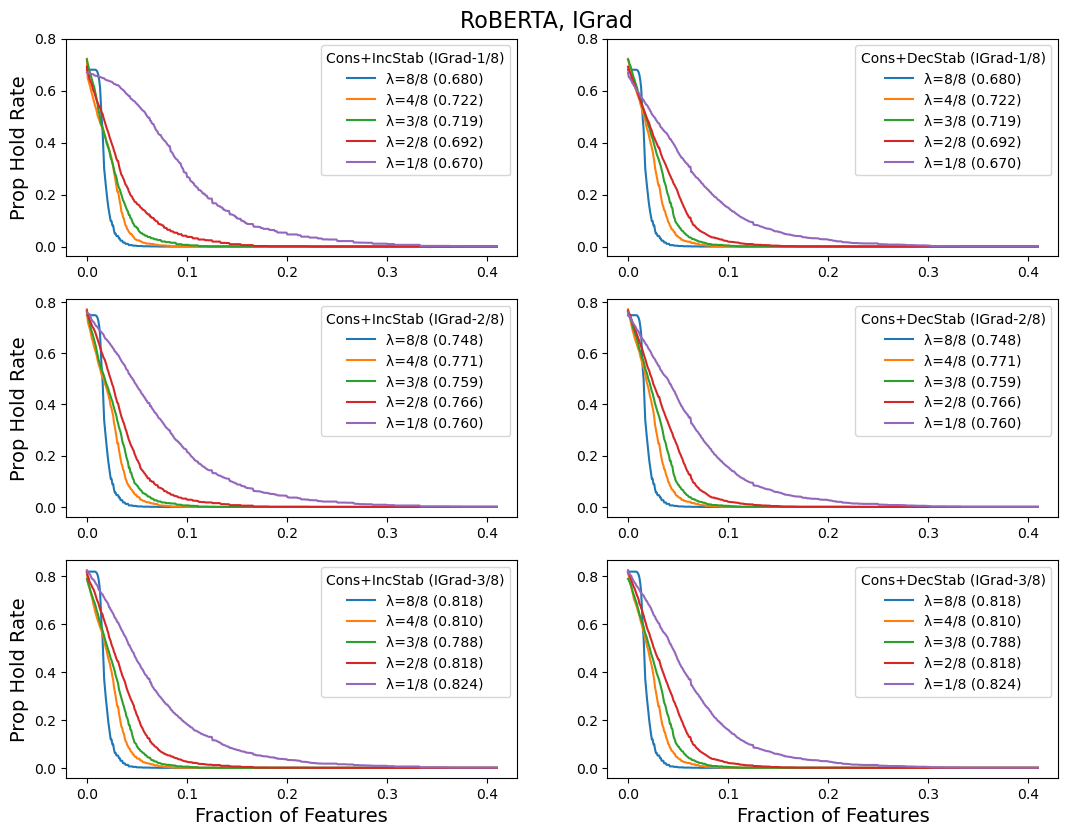

In [9]:
q1t_methods = ["SHAP", "LIME", "VGrad", "IGrad"]

q1t_vit16_rs = np.linspace(0.0, 4.5, 500)
q1t_vit16_plot_rs = q1t_vit16_rs / 64
for method in q1t_methods:
    title = f"Vision Transformer, {method}"
    _ = q1_plot_method("ViT16", method, q1t_vit16_rs, q1t_vit16_plot_rs, title=title)
    plt.savefig(f"images/q1_methods_vit16_{method.lower()}.png", bbox_inches="tight")

q1t_resnet50_rs = q1t_vit16_rs
q1t_resnet50_plot_rs = q1t_vit16_plot_rs
for method in q1t_methods:
    title = f"ResNet50, {method}"
    _ = q1_plot_method("ResNet50", method, q1t_resnet50_rs, q1t_resnet50_plot_rs, title=title)
    plt.savefig(f"images/q1_methods_resnet50_{method.lower()}.png", bbox_inches="tight")

q1t_roberta_rs = np.linspace(0.0, 0.41, 500)
q1t_roberta_plot_rs = np.linspace(0.0, 0.41, 500)
for method in q1t_methods:
    title = f"RoBERTA, {method}"
    _ = q1_plot_method("RoBERTa", method, q1t_roberta_rs, q1t_roberta_plot_rs, title=title)
    plt.savefig(f"images/q1_methods_roberta_{method.lower()}.png", bbox_inches="tight")
    

In [10]:
##################################################################
### Certified and empirical stability, only for SHAP top-25%
##################################################################

In [11]:
def q1_plot_cert_vs_emp(model_type, trs, plot_trs, ers, plot_ers,
                        title = None,
                        lfs = 10,
                        afs = 12,
                        tfs = 14,
                        show_lhs = True,
                        subplot_titles = False):
    plt.clf()
    fig, ax = plt.subplots(2,2, figsize=(6.4 * 2, 4.8*1.2))

    q1t_lambds = [8/8, 4/8, 2/8, 1/8]
    q1e_lambds = [8/8, 4/8, 2/8, 1/8]
    q1t_dfs = [(l, load_q1_theory(model_type, "shap", 0.25, l)) for l in q1t_lambds]
    q1e_dfs = [(l, load_q1_boxatk(model_type, "shap", 0.25, l)) for l in q1e_lambds]
    div_by_p = model_type.lower() == "roberta"
    
    for (lambd, df) in q1t_dfs:
        inc_drops = q1t_drops(df, trs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, trs, prop="dec", div_by_p=div_by_p)
        if show_lhs:
            ax[0,0].plot(plot_trs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
            ax[0,1].plot(plot_trs, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})")
        else:
            ax[0,0].plot(plot_trs, inc_drops, label=f"λ={int(lambd*8)}/8")
            ax[0,1].plot(plot_trs, dec_drops, label=f"λ={int(lambd*8)}/8")
            

    for (lambd, df) in q1e_dfs:
        inc_drops = q1e_drops(df, ers, prop="inc", div_by_p=div_by_p)
        dec_drops = q1e_drops(df, ers, prop="dec", div_by_p=div_by_p)
        if show_lhs:
            ax[1,0].plot(plot_ers, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
            ax[1,1].plot(plot_ers, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})")
        else:
            ax[1,0].plot(plot_ers, inc_drops, label=f"λ={int(lambd*8)}/8")
            ax[1,1].plot(plot_ers, dec_drops, label=f"λ={int(lambd*8)}/8")
        
    if subplot_titles:
        emp_legend_loc = "lower left" if model_type == "roberta" else "upper right"
        ax[0,0].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
        ax[0,1].legend(loc="upper right", title_fontsize=lfs)
        ax[1,0].legend(loc=emp_legend_loc, fontsize=lfs, title_fontsize=lfs)
        ax[1,1].legend(loc=emp_legend_loc, fontsize=lfs, title_fontsize=lfs)
        
        ax[0,0].set_title("Certified Consistent and Inc Stable", fontsize=tfs)
        ax[0,1].set_title("Certified Consistent and Dec Stable", fontsize=tfs)
        ax[1,0].set_title("Empirical Consistent and Inc Stable", fontsize=tfs)
        ax[1,1].set_title("Empirical Consistent and Dec Stable", fontsize=tfs)
        fig.subplots_adjust(hspace=0.35)
        
    else:
        emp_legend_loc = "lower left" if model_type == "roberta" else "upper right"
        ax[0,0].legend(loc="upper right", title="Cert Cons+IncStab", fontsize=lfs, title_fontsize=lfs)
        ax[0,1].legend(loc="upper right", title="Cert Cons+DecStab", fontsize=lfs, title_fontsize=lfs)
        ax[1,0].legend(loc=emp_legend_loc, title="Emp Cons+IncStab", fontsize=lfs, title_fontsize=lfs)
        ax[1,1].legend(loc=emp_legend_loc, title="Emp Cons+DecStab", fontsize=lfs, title_fontsize=lfs)
        
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
            ax[i,j].tick_params(axis="x", labelsize=lfs)
            ax[i,j].tick_params(axis="y", labelsize=lfs)

    ax[1,0].set_xlabel("Fraction of Features", fontsize=afs)
    ax[1,1].set_xlabel("Fraction of Features", fontsize=afs)
    ax[0,0].set_ylabel("Prop Hold Rate", fontsize=afs)
    ax[1,0].set_ylabel("Prop Hold Rate", fontsize=afs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.93)
    
    return fig

<Figure size 640x480 with 0 Axes>

<Figure size 1280x576 with 0 Axes>

<Figure size 1280x576 with 0 Axes>

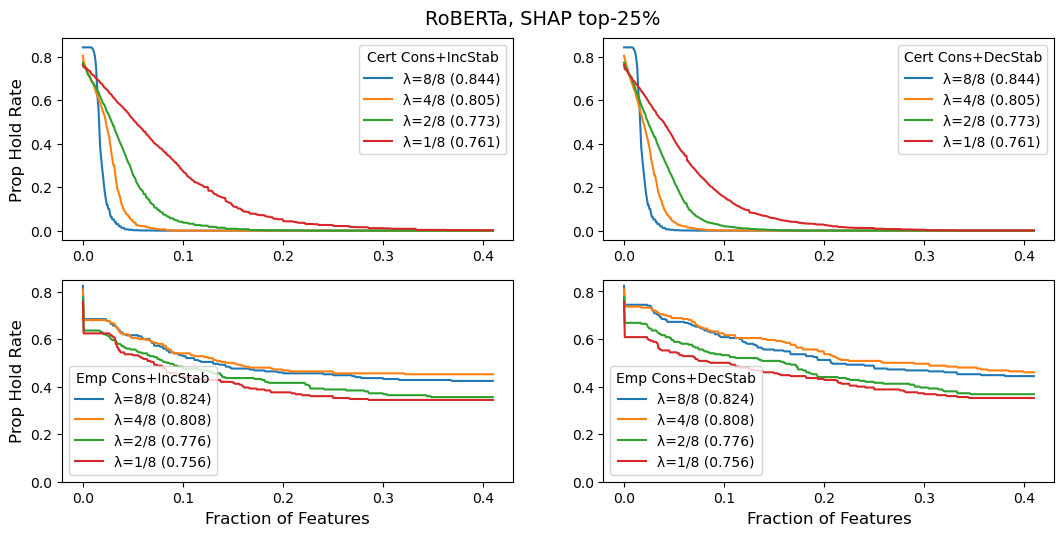

In [12]:
q1t_vit16_rs = np.linspace(0.0, 4.5, 500)
q1t_vit16_plot_rs = q1t_vit16_rs / 64
q1e_vit16_rs = np.linspace(0.0, 31.9, 500)
q1e_vit16_plot_rs = q1e_vit16_rs / 64
_ = q1_plot_cert_vs_emp("vit16", q1t_vit16_rs, q1t_vit16_plot_rs, q1e_vit16_rs, q1e_vit16_plot_rs, title="Vision Transformer, SHAP top-25%")
plt.savefig("images/q1_emp_vit16.png", bbox_inches="tight")



q1t_resnet50_rs = q1t_vit16_rs
q1t_resnet50_plot_rs = q1t_vit16_plot_rs
q1e_resnet50_rs = q1e_vit16_rs
q1e_resnet50_plot_rs = q1e_vit16_plot_rs
_ = q1_plot_cert_vs_emp("resnet50", q1t_resnet50_rs, q1t_resnet50_plot_rs, q1e_resnet50_rs, q1e_resnet50_plot_rs, title="ResNet50, SHAP top-25%")
plt.savefig("images/q1_emp_resnet50.png", bbox_inches="tight")


q1t_roberta_rs = np.linspace(0.0, 0.41, 500)
q1t_roberta_plot_rs = np.linspace(0.0, 0.41, 500)
q1e_roberta_rs = q1t_roberta_rs
q1e_roberta_plot_rs = q1t_roberta_plot_rs
_ = q1_plot_cert_vs_emp("roberta", q1t_roberta_rs, q1t_roberta_plot_rs, q1e_roberta_rs, q1e_roberta_plot_rs, title="RoBERTa, SHAP top-25%")
plt.savefig("images/q1_emp_roberta.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

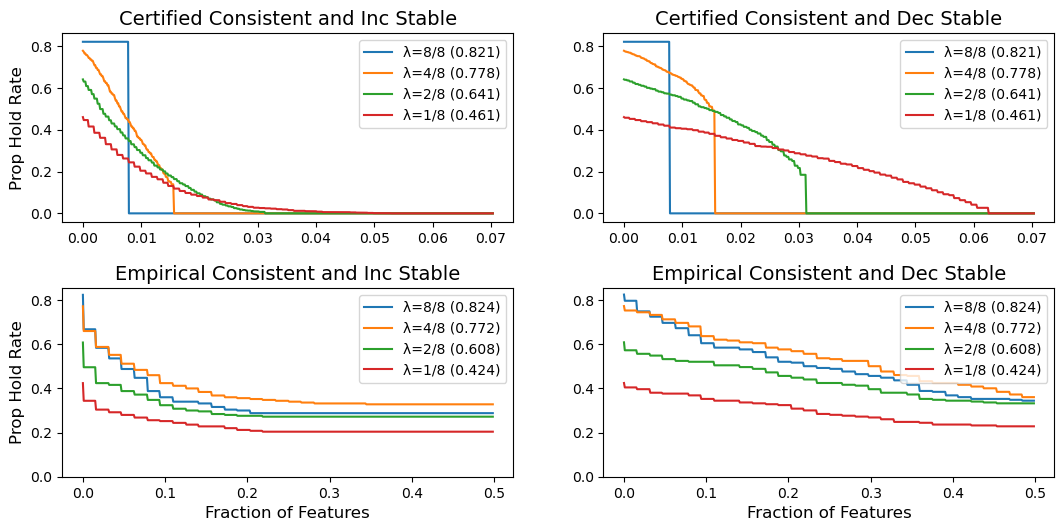

In [13]:

_ = q1_plot_cert_vs_emp("vit16", q1t_vit16_rs, q1t_vit16_plot_rs, q1e_vit16_rs, q1e_vit16_plot_rs,
                        title=None, show_lhs=True, subplot_titles=True)
plt.savefig("images/q1.png", bbox_inches="tight")

In [14]:
#######################################################
# Certified accuracy drop plots
#######################################################

In [15]:
def load_q2(model_type, lambd):
    if model_type == "roberta":
        csv_file = f"q2_{model_type}_q64_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q2_{model_type}_psz28_q64_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q2_DIR, csv_file)
    return pd.read_csv(csv_file)

def q2_drops(df, rs, div_by_p=False):
    true_labels = df["true_label"].to_numpy()
    ones_labels = df["ones_label"].to_numpy()
    N = len(df)
    hit_bits = true_labels == ones_labels
    cert_rs = df["cert_r"].to_numpy()
    if div_by_p:
        ps = df["p"].to_numpy()
        cert_rs = cert_rs / ps
    drops = np.array([hit_bits[cert_rs >= r].sum() / N for r in rs])
    return drops


In [16]:
q2_lambds = [16/16, 8/16, 4/16, 2/16, 1/16]

def lambd_str(lam):
    if abs(16 * lam - 1) < 1e-4:
        return "1/16"
    else:
        return f"{str(int(lambd*8))}/8"

q2_vit16_dfs = [(l,load_q2("vit16", l)) for l in q2_lambds]
q2_resnet50_dfs = [(l,load_q2("resnet50", l)) for l in q2_lambds]
q2_roberta_dfs = [(l,load_q2("roberta", l)) for l in q2_lambds]

In [17]:
q2_rs = np.linspace(0.0, 10.01, 802)
q2_rs_roberta = np.linspace(0.0, 0.501, 502)

<Figure size 640x480 with 0 Axes>

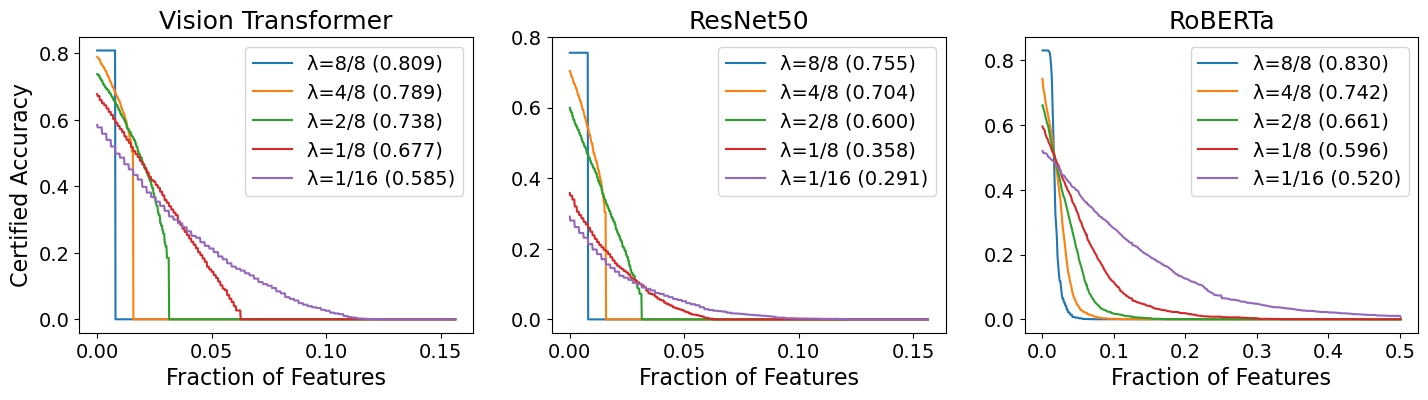

In [18]:
### The version in the main paper

plt.clf()
lfs, afs, tfs = 14, 16, 18
fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))

for (lambd, df) in q2_vit16_dfs:
    drops = q2_drops(df, q2_rs)
    ax[0].plot(q2_rs/64, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})")

for (lambd, df) in q2_resnet50_dfs:
    drops = q2_drops(df, q2_rs)
    ax[1].plot(q2_rs/64, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})")

for (lambd, df) in q2_roberta_dfs:
    drops = q2_drops(df, q2_rs_roberta, div_by_p=True)
    ax[2].plot(q2_rs_roberta, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})")


# ax[0].legend(loc="upper right", title="Vision Transformer", fontsize=lfs, title_fontsize=lfs)
# ax[1].legend(loc="upper right", title="ResNet50", fontsize=lfs, title_fontsize=lfs)
# ax[2].legend(loc="upper right", title="RoBERTa", fontsize=lfs, title_fontsize=lfs)

ax[0].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
ax[1].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
ax[2].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)

ax[0].set_title("Vision Transformer", fontsize=tfs)
ax[1].set_title("ResNet50", fontsize=tfs)
ax[2].set_title("RoBERTa", fontsize=tfs)

ax[0].set_ylabel("Certified Accuracy", fontsize=afs)
ax[0].tick_params(axis="y", labelsize=lfs)
for i in [0,1,2]:
    ax[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    ax[i].set_xlabel("Fraction of Features", fontsize=afs)
    ax[i].tick_params(axis="x", labelsize=lfs)
    ax[i].tick_params(axis="y", labelsize=lfs)

plt.savefig("images/q2.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

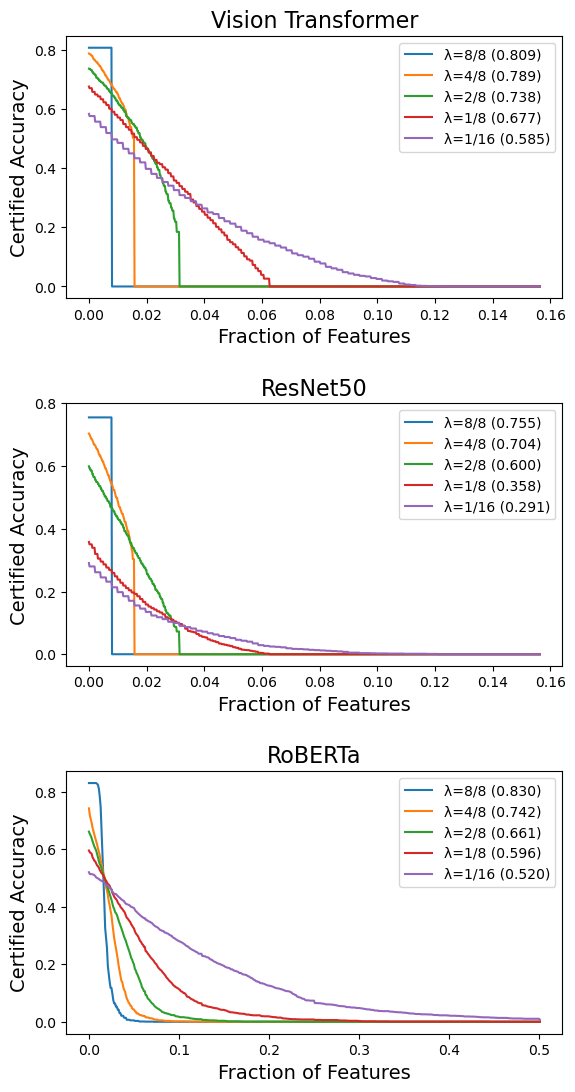

In [19]:
### The version in the appendix

plt.clf()

lfs, afs, tfs = 10, 14, 16
fig, ax = plt.subplots(3,1, figsize=(6.4 * 1, 4.8 * 2.7))

fig.subplots_adjust(hspace=0.4)

for (lambd, df) in q2_vit16_dfs:
    drops = q2_drops(df, q2_rs)
    ax[0].plot(q2_rs/64, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})")

for (lambd, df) in q2_resnet50_dfs:
    drops = q2_drops(df, q2_rs)
    ax[1].plot(q2_rs/64, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})")

for (lambd, df) in q2_roberta_dfs:
    drops = q2_drops(df, q2_rs_roberta, div_by_p=True)
    ax[2].plot(q2_rs_roberta, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})")

ax[0].set_title("Vision Transformer", fontsize=tfs)
ax[1].set_title("ResNet50", fontsize=tfs)
ax[2].set_title("RoBERTa", fontsize=tfs)

ax[0].tick_params(axis="y", labelsize=lfs)
for i in [0,1,2]:
    ax[i].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
    ax[i].set_ylabel("Certified Accuracy", fontsize=afs)
    ax[i].set_xlabel("Fraction of Features", fontsize=afs)
    ax[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    ax[i].tick_params(axis="x", labelsize=lfs)
    ax[i].tick_params(axis="y", labelsize=lfs)
#     ax[i].legend(loc="upper right")

plt.savefig("images/q2_appendix.png", bbox_inches="tight")

In [20]:
#######################################################
# Q3 Plots
#######################################################

In [21]:
def load_q3_df(model_type, method_type, lambd):
    if model_type == "roberta":
        csv_file = f"q3s_{model_type}_q64_{method_type}_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q3s_{model_type}_psz28_q64_{method_type}_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q3_DIR, csv_file)
    return pd.read_csv(csv_file)

def q3_fracs(df):
    p = df["p"].to_numpy()
    k = df["k"].to_numpy()
    return (k/p).mean()

def q3_accs(df):
    N = len(df)
    true_labels = df["true_label"].to_numpy()
    exbs_labels = df["exbs_label"].to_numpy()
    return (true_labels == exbs_labels).sum() / N

In [22]:
q3_lambds = [1/8., 2/8., 3/8., 4/8.]


q3_vit16_shaps = [q3_fracs(load_q3_df("vit16", "shap", l)) for l in q3_lambds]
q3_vit16_limes = [q3_fracs(load_q3_df("vit16", "lime", l)) for l in q3_lambds]
q3_vit16_igradus = [q3_fracs(load_q3_df("vit16", "igradu", l)) for l in q3_lambds]
q3_vit16_vgradus = [q3_fracs(load_q3_df("vit16", "vgradu", l)) for l in q3_lambds]

q3_resnet50_shaps = [q3_fracs(load_q3_df("resnet50", "shap", l)) for l in q3_lambds]
q3_resnet50_limes = [q3_fracs(load_q3_df("resnet50", "lime", l)) for l in q3_lambds]
q3_resnet50_igradus = [q3_fracs(load_q3_df("resnet50", "igradu", l)) for l in q3_lambds]
q3_resnet50_vgradus = [q3_fracs(load_q3_df("resnet50", "vgradu", l)) for l in q3_lambds]

q3_roberta_shaps = [q3_fracs(load_q3_df("roberta", "shap", l)) for l in q3_lambds]
q3_roberta_limes = [q3_fracs(load_q3_df("roberta", "lime", l)) for l in q3_lambds]
q3_roberta_igradus = [q3_fracs(load_q3_df("roberta", "igradu", l)) for l in q3_lambds]
q3_roberta_vgradus = [q3_fracs(load_q3_df("roberta", "vgradu", l)) for l in q3_lambds]

q3_data = [("Vision Transformer",
                ("VGrad", q3_vit16_vgradus),
                ("IGrad", q3_vit16_igradus),
                ("LIME", q3_vit16_limes),
                ("SHAP", q3_vit16_shaps)),
           
           ("ResNet50",
                ("VGrad", q3_resnet50_vgradus),
                ("IGrad", q3_resnet50_igradus),
                ("LIME", q3_resnet50_limes),
                ("SHAP", q3_resnet50_shaps)),
          
           ("RoBERTa",
                ("VGrad", q3_roberta_vgradus),
                ("IGrad", q3_roberta_igradus),
                ("LIME", q3_roberta_limes),
                ("SHAP", q3_roberta_shaps)),
          ]

<Figure size 640x480 with 0 Axes>

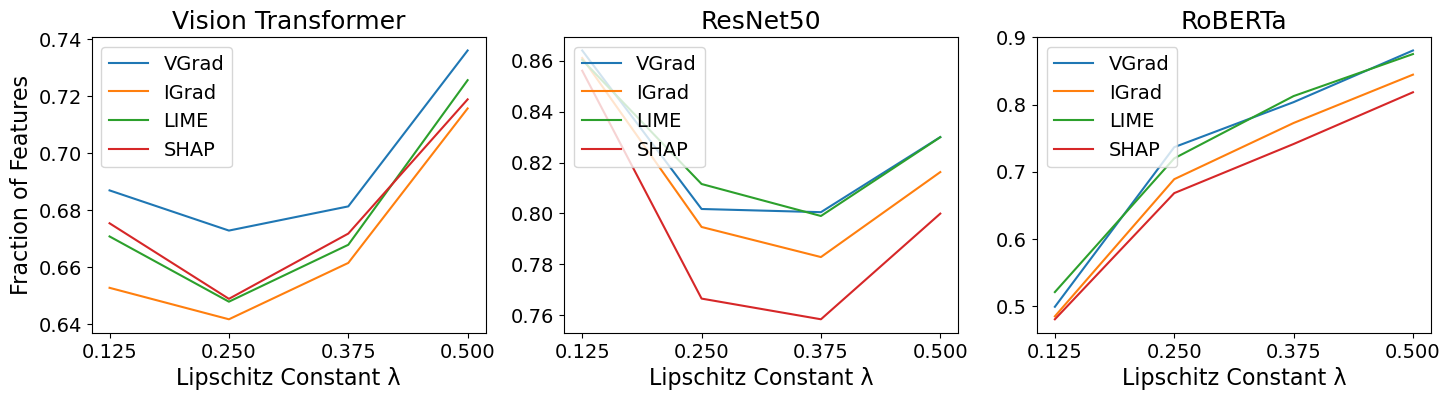

In [23]:
### Main paper plot
plt.clf()
lfs, afs, tfs = 14, 16, 18
fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))

for i, (title, f1, f2, f3, f4) in enumerate(q3_data):
    ax[i].plot(q3_lambds, f1[1], label=f1[0])
    ax[i].plot(q3_lambds, f2[1], label=f2[0])
    ax[i].plot(q3_lambds, f3[1], label=f3[0])
    ax[i].plot(q3_lambds, f4[1], label=f4[0])
#     ax[i].legend(loc="upper left", title=title, fontsize=lfs, title_fontsize=lfs)
    ax[i].legend(loc="upper left", fontsize=lfs, title_fontsize=lfs)
    ax[i].set_xlabel("Lipschitz Constant λ", fontsize=afs)
    ax[i].set_xticks(q3_lambds)
    ax[i].tick_params(axis="x", labelsize=lfs)
    ax[i].tick_params(axis="y", labelsize=lfs)

    
ax[0].set_title("Vision Transformer", fontsize=tfs)
ax[1].set_title("ResNet50", fontsize=tfs)
ax[2].set_title("RoBERTa", fontsize=tfs)
ax[0].set_ylabel("Fraction of Features", fontsize=afs)

plt.savefig("images/q3.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

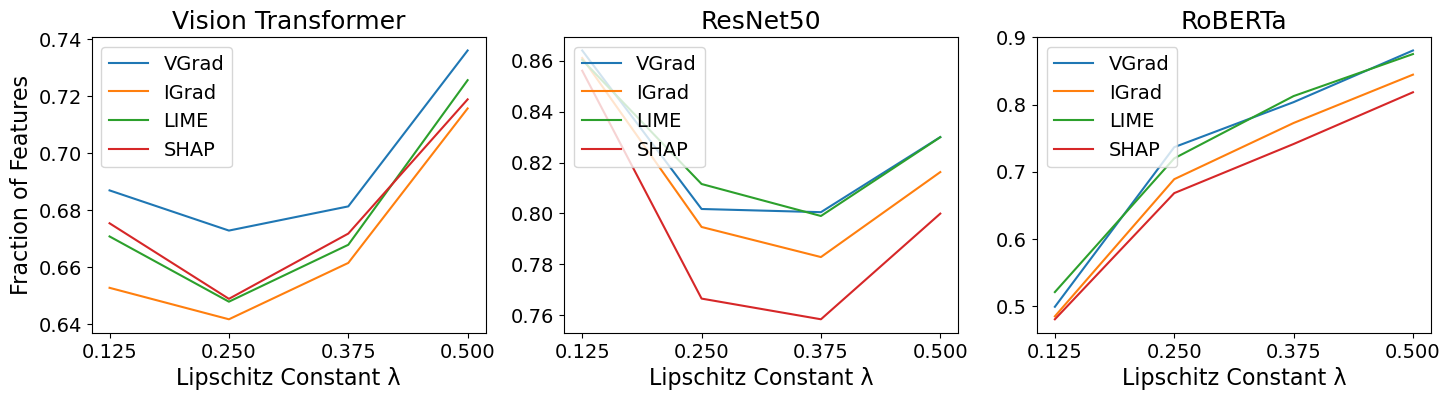

In [24]:
### Appendix version of q3 plot
plt.clf()
lfs, afs, tfs = 14, 16, 18
fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))

for i, (title, f1, f2, f3, f4) in enumerate(q3_data):
    ax[i].plot(q3_lambds, f1[1], label=f1[0])
    ax[i].plot(q3_lambds, f2[1], label=f2[0])
    ax[i].plot(q3_lambds, f3[1], label=f3[0])
    ax[i].plot(q3_lambds, f4[1], label=f4[0])
#     ax[i].legend(loc="upper left", title=title, fontsize=lfs, title_fontsize=lfs)
    ax[i].legend(loc="upper left", fontsize=lfs, title_fontsize=lfs)
    ax[i].set_xlabel("Lipschitz Constant λ", fontsize=afs)
    ax[i].set_xticks(q3_lambds)
    ax[i].tick_params(axis="x", labelsize=lfs)
    ax[i].tick_params(axis="y", labelsize=lfs)
    
ax[0].set_title("Vision Transformer", fontsize=tfs)
ax[1].set_title("ResNet50", fontsize=tfs)
ax[2].set_title("RoBERTa", fontsize=tfs)

ax[0].set_ylabel("Fraction of Features", fontsize=afs)

plt.savefig("images/q3_appendix.png", bbox_inches="tight")

In [25]:
def plot_q3_method_comps(model_type,
                         title = None,
                         lfs = 14,
                         afs = 16,
                         tfs = 18):
    plt.clf()
    fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))
    
    methods = ["VGrad", "IGrad", "LIME", "SHAP"]
    lambds = [1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 8/8]
    
    for i in range(3):
        vgrad_accs = [(q3_accs(load_q1_theory(model_type.lower(), "vgrad", (i+1)/8, l))) for l in lambds]
        igrad_accs = [(q3_accs(load_q1_theory(model_type.lower(), "igrad", (i+1)/8, l))) for l in lambds]
        lime_accs = [(q3_accs(load_q1_theory(model_type.lower(), "lime", (i+1)/8, l))) for l in lambds]
        shap_accs = [(q3_accs(load_q1_theory(model_type.lower(), "shap", (i+1)/8, l))) for l in lambds]
        
        ax[i].plot(lambds, vgrad_accs, label="VGrad")
        ax[i].plot(lambds, igrad_accs, label="IGrad")
        ax[i].plot(lambds, lime_accs, label="LIME")
        ax[i].plot(lambds, shap_accs, label="SHAP")
        
        ax[i].legend(loc="lower right", title=f"Top-{i+1}/8", fontsize=lfs, title_fontsize=lfs)
        ax[i].set_xlabel("Lipschitz Constant λ", fontsize=afs)
        ax[i].tick_params(axis="x", labelsize=lfs)
        ax[i].tick_params(axis="y", labelsize=lfs)
    
    ax[0].set_ylabel("φ(x)-Masked Accuracy", fontsize=afs)
        
    if title is not None:
        fig.suptitle(title, fontsize=tfs)
        
    return fig

<Figure size 640x480 with 0 Axes>

<Figure size 1728x384 with 0 Axes>

<Figure size 1728x384 with 0 Axes>

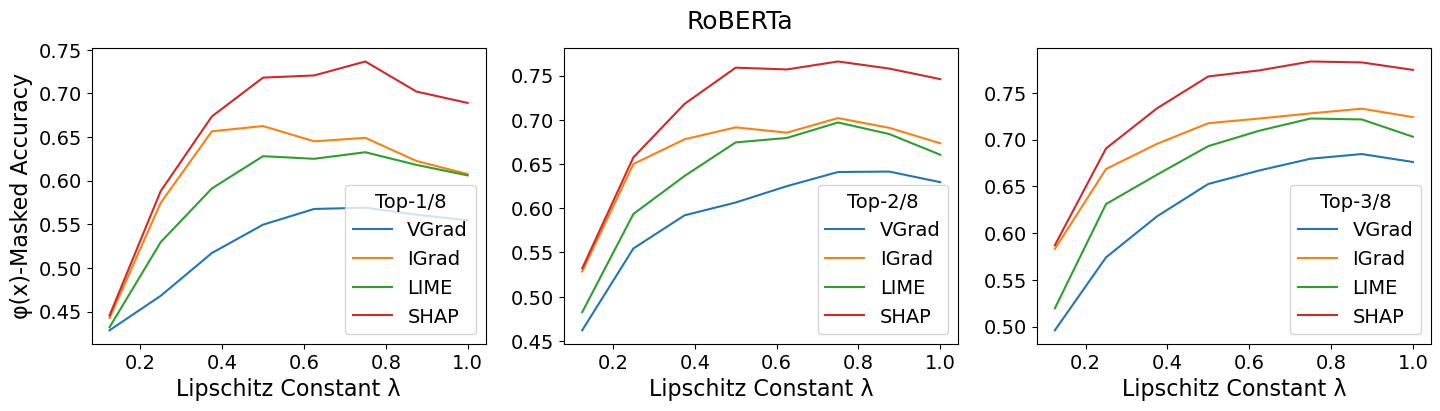

In [26]:
fig = plot_q3_method_comps("vit16", title="Vision Transformer")
plt.savefig("images/q3_methods_accs_vit16.png", bbox_inches="tight")

fig = plot_q3_method_comps("resnet50", title="ResNet50")
plt.savefig("images/q3_methods_accs_resnet50.png", bbox_inches="tight")

fig = plot_q3_method_comps("roberta", title="RoBERTa")
plt.savefig("images/q3_methods_accs_roberta.png", bbox_inches="tight")


In [27]:
###########################3

In [28]:

testdf = load_q1_boxatk("vit16", "shap", 0.25, 0.5)
testdf

,Unnamed: 0,data_ind,lambd,p,nnz,true_label,ones_label,exbs_label,ones_mu_label,exbs_mu_label,ones_gap,exbs_gap,ones_mu_gap,exbs_mu_gap,inc_init_r_max,inc_curr_r_max,inc_max_dist,inc_num_resets,inc_num_ces,dec_init_r_max,dec_curr_r_max,dec_max_dist,dec_num_resets,dec_num_ces
0,0,0,0.5,64,16,395,26,26,26,26,0.3125,0.0625,1.0000,1.0,8,0,0,0,1,8,3,6,20,4
1,1,1,0.5,64,16,838,838,838,838,838,0.3125,0.1250,0.5000,1.0,8,4,5,13,2,8,5,8,13,3
2,2,2,0.5,64,16,873,873,873,873,873,1.0000,0.3750,1.0000,1.0,32,32,28,6,0,32,32,32,3,0
3,3,3,0.5,64,16,2,2,2,2,2,1.0000,1.0000,1.0000,1.0,32,32,32,7,0,32,32,27,4,0
4,4,4,0.5,64,16,534,534,534,534,534,1.0000,0.2500,1.0000,1.0,8,1,7,13,5,32,31,32,4,1
5,5,5,0.5,64,16,269,269,269,269,269,1.0000,0.7500,1.0000,1.0,16,9,11,7,3,24,20,24,5,2
6,6,6,0.5,64,16,885,709,709,709,709,0.7500,0.4375,1.0000,1.0,8,4,6,12,2,8,5,7,13,2
7,7,7,0.5,64,16,590,508,681,810,810,0.4375,0.2500,1.0000,1.0,8,0,0,0,1,8,2,3,24,4
8,8,8,0.5,64,16,133,133,133,133,133,1.0000,1.0000,1.0000,1.0,32,32,31,5,0,32,32,32,4,0
9,9,9,0.5,64,16,280,280,286,280,280,1.0000,0.1250,1.0000,1.0,8,0,0,0,1,8,5,7,14,2
